# Anomalies in `emissions_all_buurt`

- **Descriptive statistics:** Summarize the key columns (construction, renovation, transformation, demolition, embodied_kg, operational_kg, etc.) by calculating: Mean, median, minimum, maximum, and standard deviation.
- **Per Capita and Per Household Analysis:** Calculate emissions per capita and per household (population, n_homes). Compare these values across municipalities to identify outliers.
- **Time series trends:** Plot the annual totals for emissions (embodied_kg, operational_kg) and other relevant metrics (like construction, renovation) for each year. Look for unexpected spikes or drops.
- **Consistency checks:** 
    - Emissions vs. Activity: Ensure embodied_kg aligns with construction and demolition activities.
    - Energy Use vs. Operational Emissions: Check if operational emissions (operational_kg) correlate with total energy use (tot_gas_m3 and tot_elec_kwh).
- **Geographical comparison:** Map emissions (embodied_kg, operational_kg) and other metrics to identify spatial anomalies, such as one municipality significantly higher or lower than its neighbors.

In [1]:
from sqlalchemy import create_engine
import pandas as pd
import geopandas as gpd
import psycopg2
from psycopg2 import sql
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import folium
import os

# move current directory to /Users/tanyatsui/Documents/01_Projects/housingEmissions
os.chdir('/Users/tanyatsui/Documents/01_Projects/housingEmissions')

In [2]:
# create a connection to the database
db_name = 'urbanmining'
db_user = 'postgres'
db_password = 'Tunacompany5694!'
db_host = 'localhost'
db_port = '5432'
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')


# Descriptive statistics
Summarize the key columns (construction, renovation, transformation, demolition, embodied_kg, operational_kg, etc.) by calculating: Mean, median, minimum, maximum, and standard deviation.

In [9]:
query = ''' 
SELECT
    'construction' AS column_name,
    MIN(construction) AS min_value,
    MAX(construction) AS max_value,
    AVG(construction) AS avg_value,
    STDDEV(construction) AS stddev_value,
    SUM(construction) AS sum_value,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY construction) AS median_value
FROM emissions_all_buurt
UNION ALL
SELECT
    'renovation',
    MIN(renovation),
    MAX(renovation),
    AVG(renovation),
    STDDEV(renovation),
    SUM(renovation),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY renovation)
FROM emissions_all_buurt
UNION ALL
SELECT
    'transformation',
    MIN(transformation),
    MAX(transformation),
    AVG(transformation),
    STDDEV(transformation),
    SUM(transformation),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY transformation)
FROM emissions_all_buurt
UNION ALL
SELECT
    'demolition',
    MIN(demolition),
    MAX(demolition),
    AVG(demolition),
    STDDEV(demolition),
    SUM(demolition),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY demolition)
FROM emissions_all_buurt
UNION ALL
SELECT
    'population',
    MIN(population),
    MAX(population),
    AVG(population),
    STDDEV(population),
    SUM(population),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY population)
FROM emissions_all_buurt
UNION ALL
SELECT
    'n_homes',
    MIN(n_homes),
    MAX(n_homes),
    AVG(n_homes),
    STDDEV(n_homes),
    SUM(n_homes),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY n_homes)
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_gas_m3',
    MIN(tot_gas_m3),
    MAX(tot_gas_m3),
    AVG(tot_gas_m3),
    STDDEV(tot_gas_m3),
    SUM(tot_gas_m3),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_gas_m3)
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_elec_kwh',
    MIN(tot_elec_kwh),
    MAX(tot_elec_kwh),
    AVG(tot_elec_kwh),
    STDDEV(tot_elec_kwh),
    SUM(tot_elec_kwh),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_elec_kwh)
FROM emissions_all_buurt
UNION ALL
SELECT
    'woz',
    MIN(woz),
    MAX(woz),
    AVG(woz),
    STDDEV(woz),
    SUM(woz),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY woz)
FROM emissions_all_buurt
UNION ALL
SELECT
    'embodied_kg',
    MIN(embodied_kg),
    MAX(embodied_kg),
    AVG(embodied_kg),
    STDDEV(embodied_kg),
    SUM(embodied_kg),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY embodied_kg)
FROM emissions_all_buurt
UNION ALL
SELECT
    'operational_kg',
    MIN(operational_kg),
    MAX(operational_kg),
    AVG(operational_kg),
    STDDEV(operational_kg),
    SUM(operational_kg),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY operational_kg)
FROM emissions_all_buurt;

'''

df = pd.read_sql_query(query, engine)
df

,column_name,min_value,max_value,avg_value,stddev_value,sum_value,median_value
0,construction,0.0,65894.0,3.964708e+02,1.773443e+03,5.529142e+07,0.00
1,operational_kg,0.0,48541500.0,2.129587e+06,2.591828e+06,2.912722e+11,1307285.75
2,embodied_kg,0.0,43694658.0,1.901276e+05,6.372916e+05,2.651501e+10,18900.00
3,woz,0.0,2113.0,2.297924e+02,1.481001e+02,3.094408e+07,225.00
4,renovation,0.0,346783.0,3.044076e+02,1.591268e+03,4.245238e+07,0.00
5,demolition,0.0,233770.0,1.084459e+02,9.983578e+02,1.512376e+07,0.00
6,n_homes,0.0,14330.0,5.546853e+02,7.397044e+02,7.650553e+07,307.00
7,tot_elec_kwh,0.0,37331250.0,1.634464e+06,2.002723e+06,2.239052e+11,1013846.50
8,transformation,0.0,292440.0,1.437104e+02,1.117088e+03,2.004171e+07,0.00
9,population,0.0,28870.0,1.234994e+03,1.584013e+03,1.703378e+08,711.00


# Per Capita and Per Household statistics
Calculate emissions per capita and per household (population, n_homes). Compare these values across municipalities to identify outliers.

In [73]:
query = ''' 
-- Per Capita Statistics
SELECT
    'construction_per_capita' AS column_name,
    MIN(construction / NULLIF(population, 0)) AS min_value,
    MAX(construction / NULLIF(population, 0)) AS max_value,
    AVG(construction / NULLIF(population, 0)) AS avg_value,
    STDDEV(construction / NULLIF(population, 0)) AS stddev_value,
    SUM(construction / NULLIF(population, 0)) AS sum_value,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY construction / NULLIF(population, 0)) AS median_value
FROM emissions_all_buurt
UNION ALL
SELECT
    'renovation_per_capita',
    MIN(renovation / NULLIF(population, 0)),
    MAX(renovation / NULLIF(population, 0)),
    AVG(renovation / NULLIF(population, 0)),
    STDDEV(renovation / NULLIF(population, 0)),
    SUM(renovation / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY renovation / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'transformation_per_capita',
    MIN(transformation / NULLIF(population, 0)),
    MAX(transformation / NULLIF(population, 0)),
    AVG(transformation / NULLIF(population, 0)),
    STDDEV(transformation / NULLIF(population, 0)),
    SUM(transformation / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY transformation / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'demolition_per_capita',
    MIN(demolition / NULLIF(population, 0)),
    MAX(demolition / NULLIF(population, 0)),
    AVG(demolition / NULLIF(population, 0)),
    STDDEV(demolition / NULLIF(population, 0)),
    SUM(demolition / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY demolition / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_gas_m3_per_capita',
    MIN(tot_gas_m3 / NULLIF(population, 0)),
    MAX(tot_gas_m3 / NULLIF(population, 0)),
    AVG(tot_gas_m3 / NULLIF(population, 0)),
    STDDEV(tot_gas_m3 / NULLIF(population, 0)),
    SUM(tot_gas_m3 / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_gas_m3 / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_elec_kwh_per_capita',
    MIN(tot_elec_kwh / NULLIF(population, 0)),
    MAX(tot_elec_kwh / NULLIF(population, 0)),
    AVG(tot_elec_kwh / NULLIF(population, 0)),
    STDDEV(tot_elec_kwh / NULLIF(population, 0)),
    SUM(tot_elec_kwh / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_elec_kwh / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'woz_per_capita',
    MIN(woz / NULLIF(population, 0)),
    MAX(woz / NULLIF(population, 0)),
    AVG(woz / NULLIF(population, 0)),
    STDDEV(woz / NULLIF(population, 0)),
    SUM(woz / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY woz / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'embodied_kg_per_capita',
    MIN(embodied_kg / NULLIF(population, 0)),
    MAX(embodied_kg / NULLIF(population, 0)),
    AVG(embodied_kg / NULLIF(population, 0)),
    STDDEV(embodied_kg / NULLIF(population, 0)),
    SUM(embodied_kg / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY embodied_kg / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'operational_kg_per_capita',
    MIN(operational_kg / NULLIF(population, 0)),
    MAX(operational_kg / NULLIF(population, 0)),
    AVG(operational_kg / NULLIF(population, 0)),
    STDDEV(operational_kg / NULLIF(population, 0)),
    SUM(operational_kg / NULLIF(population, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY operational_kg / NULLIF(population, 0))
FROM emissions_all_buurt
UNION ALL
-- Per Household Statistics
SELECT
    'construction_per_home',
    MIN(construction / NULLIF(n_homes, 0)),
    MAX(construction / NULLIF(n_homes, 0)),
    AVG(construction / NULLIF(n_homes, 0)),
    STDDEV(construction / NULLIF(n_homes, 0)),
    SUM(construction / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY construction / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'renovation_per_home',
    MIN(renovation / NULLIF(n_homes, 0)),
    MAX(renovation / NULLIF(n_homes, 0)),
    AVG(renovation / NULLIF(n_homes, 0)),
    STDDEV(renovation / NULLIF(n_homes, 0)),
    SUM(renovation / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY renovation / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'transformation_per_home',
    MIN(transformation / NULLIF(n_homes, 0)),
    MAX(transformation / NULLIF(n_homes, 0)),
    AVG(transformation / NULLIF(n_homes, 0)),
    STDDEV(transformation / NULLIF(n_homes, 0)),
    SUM(transformation / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY transformation / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'demolition_per_home',
    MIN(demolition / NULLIF(n_homes, 0)),
    MAX(demolition / NULLIF(n_homes, 0)),
    AVG(demolition / NULLIF(n_homes, 0)),
    STDDEV(demolition / NULLIF(n_homes, 0)),
    SUM(demolition / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY demolition / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_gas_m3_per_home',
    MIN(tot_gas_m3 / NULLIF(n_homes, 0)),
    MAX(tot_gas_m3 / NULLIF(n_homes, 0)),
    AVG(tot_gas_m3 / NULLIF(n_homes, 0)),
    STDDEV(tot_gas_m3 / NULLIF(n_homes, 0)),
    SUM(tot_gas_m3 / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_gas_m3 / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'tot_elec_kwh_per_home',
    MIN(tot_elec_kwh / NULLIF(n_homes, 0)),
    MAX(tot_elec_kwh / NULLIF(n_homes, 0)),
    AVG(tot_elec_kwh / NULLIF(n_homes, 0)),
    STDDEV(tot_elec_kwh / NULLIF(n_homes, 0)),
    SUM(tot_elec_kwh / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY tot_elec_kwh / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'woz_per_home',
    MIN(woz / NULLIF(n_homes, 0)),
    MAX(woz / NULLIF(n_homes, 0)),
    AVG(woz / NULLIF(n_homes, 0)),
    STDDEV(woz / NULLIF(n_homes, 0)),
    SUM(woz / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY woz / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'embodied_kg_per_home',
    MIN(embodied_kg / NULLIF(n_homes, 0)),
    MAX(embodied_kg / NULLIF(n_homes, 0)),
    AVG(embodied_kg / NULLIF(n_homes, 0)),
    STDDEV(embodied_kg / NULLIF(n_homes, 0)),
    SUM(embodied_kg / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY embodied_kg / NULLIF(n_homes, 0))
FROM emissions_all_buurt
UNION ALL
SELECT
    'operational_kg_per_home',
    MIN(operational_kg / NULLIF(n_homes, 0)),
    MAX(operational_kg / NULLIF(n_homes, 0)),
    AVG(operational_kg / NULLIF(n_homes, 0)),
    STDDEV(operational_kg / NULLIF(n_homes, 0)),
    SUM(operational_kg / NULLIF(n_homes, 0)),
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY operational_kg / NULLIF(n_homes, 0))
FROM emissions_all_buurt; 
'''
df = pd.read_sql_query(query, engine)
df

,column_name,min_value,max_value,avg_value,stddev_value,sum_value,median_value
0,construction_per_capita,0.0,3.488600e+03,0.880386,22.221726,1.204966e+05,0.000000
1,operational_kg_per_home,0.0,1.429250e+04,4449.914833,1722.819194,6.081031e+08,4349.500000
2,embodied_kg_per_home,0.0,7.531650e+06,1183.317208,38412.000095,1.629156e+08,39.500000
3,woz_per_home,0.0,1.009000e+03,2.724709,17.766680,3.665959e+05,0.418108
4,tot_elec_kwh_per_home,0.0,9.000000e+03,3278.737182,1092.123652,4.487476e+08,3250.000000
5,tot_gas_m3_per_home,0.0,7.400000e+03,1566.695612,698.669609,2.142268e+08,1540.000000
6,transformation_per_capita,0.0,5.977500e+04,0.712039,161.909900,9.745534e+04,0.000000
7,demolition_per_capita,0.0,5.770000e+02,0.230976,3.596161,3.161323e+04,0.000000
8,tot_elec_kwh_per_capita,0.0,1.179200e+05,1391.922393,567.205945,1.893710e+08,1377.208130
9,embodied_kg_per_capita,0.0,7.531650e+06,451.511137,21607.537075,6.179743e+07,18.121673


In [94]:
query = ''' 
SELECT 
    construction / population AS construction_per_capita,
    renovation / population AS renovation_per_capita,
    transformation / population AS transformation_per_capita,
    demolition / population AS demolition_per_capita, 

    embodied_kg / population AS embodied_kg_per_capita,
    operational_kg / population AS operational_kg_per_capita,

    *
FROM emissions_all_buurt 
WHERE municipality IS NOT NULL AND population > 0
'''
df = pd.read_sql_query(query, engine)

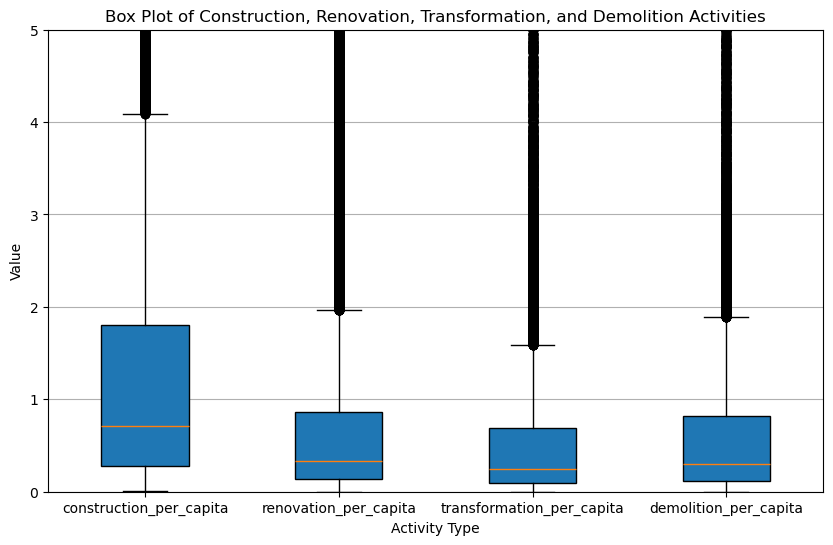

In [84]:
# Select the columns for the box plot
columns = ["construction", "renovation", "transformation", "demolition"]
columns = ['construction_per_capita', 'renovation_per_capita', 'transformation_per_capita', 'demolition_per_capita']
filtered_data = [df[col][df[col] > 0] for col in columns]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_data, vert=True, patch_artist=True, labels=columns)

# Customize the plot
plt.title("Box Plot of Construction, Renovation, Transformation, and Demolition Activities")
plt.ylabel("Value")
plt.xlabel("Activity Type")
plt.grid(axis="y")
plt.ylim(0,5)
# plt.yscale('log')

# Show the plot
plt.show()

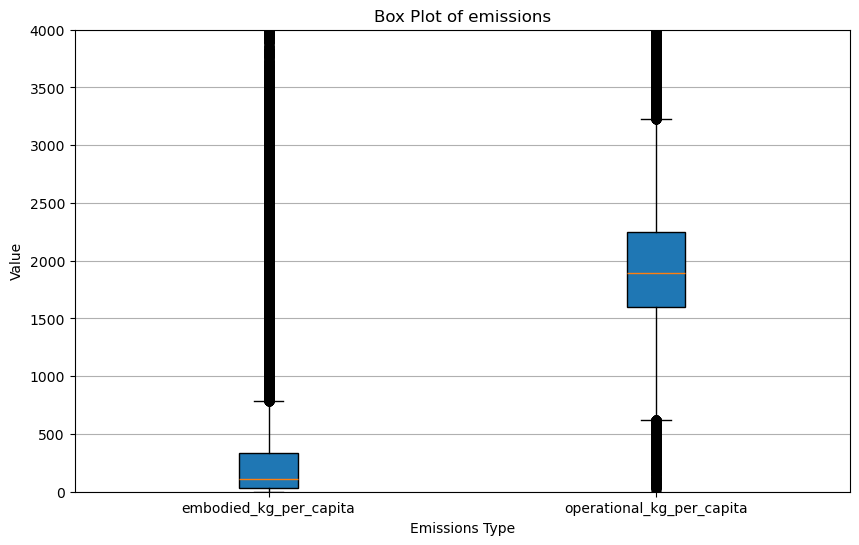

In [103]:
# Select the columns for the box plot
columns = ['embodied_kg', 'operational_kg']
columns = ['embodied_kg_per_capita', 'operational_kg_per_capita']
filtered_data = [df[col][df[col] > 0] for col in columns]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_data, vert=True, patch_artist=True, labels=columns)

# Customize the plot
plt.title("Box Plot of emissions")
plt.ylabel("Value")
plt.xlabel("Emissions Type")
plt.grid(axis="y")
plt.ylim(0,4000)
# plt.yscale('log')

# Show the plot
plt.show()

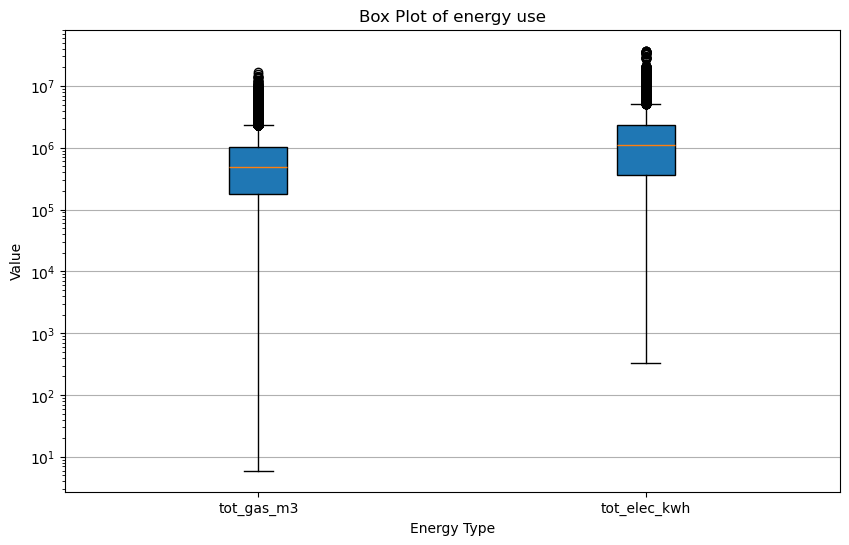

In [111]:
# Select the columns for the box plot
columns = ['tot_gas_m3', 'tot_elec_kwh']
filtered_data = [df[col][df[col] > 0] for col in columns]

# Create the box plot
plt.figure(figsize=(10, 6))
plt.boxplot(filtered_data, vert=True, patch_artist=True, labels=columns)

# Customize the plot
plt.title("Box Plot of energy use")
plt.ylabel("Value")
plt.xlabel("Energy Type")
plt.grid(axis="y")
# plt.ylim(0,6000000)
plt.yscale('log')

# Show the plot
plt.show()

# Consistency checks
- Emissions vs. Activity: Ensure embodied_kg aligns with construction and demolition activities.
- Energy Use vs. Operational Emissions: Check if operational emissions (operational_kg) correlate with total energy use (tot_gas_m3 and tot_elec_kwh).


In [ ]:
query = ''' 
SELECT * FROM emissions_all_buurt WHERE municipality IS NOT NULL
'''
data = pd.read_sql_query(query, engine)

In [51]:
data.head()

,municipality,wk_code,bu_code,bu_geom,year,construction,renovation,transformation,demolition,population,n_homes,tot_gas_m3,tot_elec_kwh,woz,embodied_kg,operational_kg
0,Uithoorn,WK045195,BU04519500,01030000204071000001000000EB010000009FCDAA4826...,2018,0.0,0.0,0.0,0.0,105.0,60.0,136800.0,194400.0,0.0,0.0,347400.0
1,Uithoorn,WK045195,BU04519500,01030000204071000001000000EB010000009FCDAA4826...,2019,0.0,0.0,0.0,0.0,100.0,60.0,127800.0,214800.0,0.0,0.0,339480.0
2,Uithoorn,WK045195,BU04519500,01030000204071000001000000EB010000009FCDAA4826...,2020,0.0,96.0,0.0,0.0,115.0,60.0,102000.0,205800.0,434.0,12096.0,286410.0
3,Uithoorn,WK045195,BU04519500,01030000204071000001000000EB010000009FCDAA4826...,2021,0.0,0.0,0.0,0.0,110.0,62.0,127720.0,259160.0,396.0,0.0,359290.0
4,Vught,WK086500,BU08650003,010300002040710000010000002B000000801B0DE08809...,2015,1469.0,0.0,0.0,583.0,970.0,377.0,1014130.0,1926470.0,648.0,509095.0,2793758.5


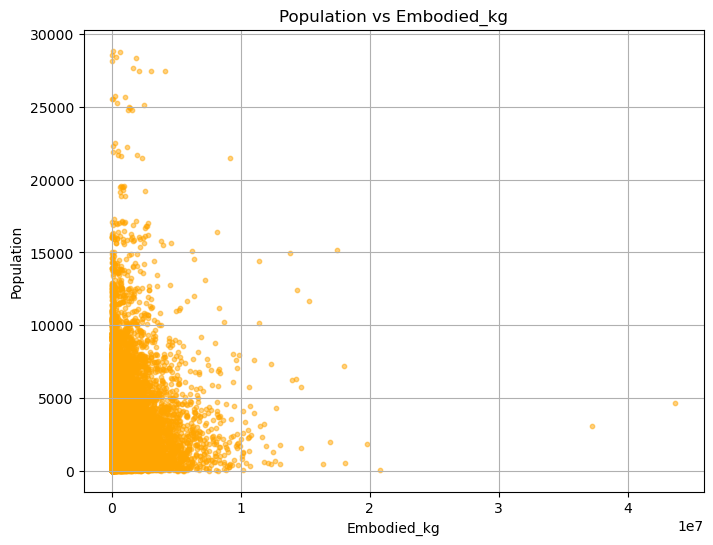

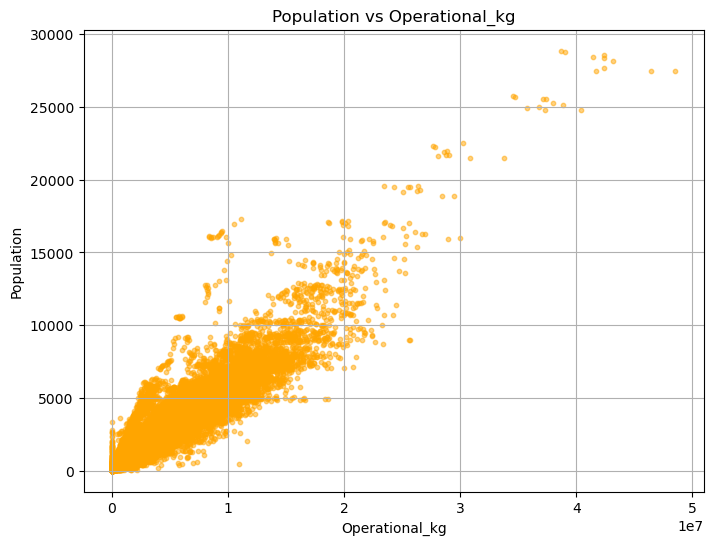

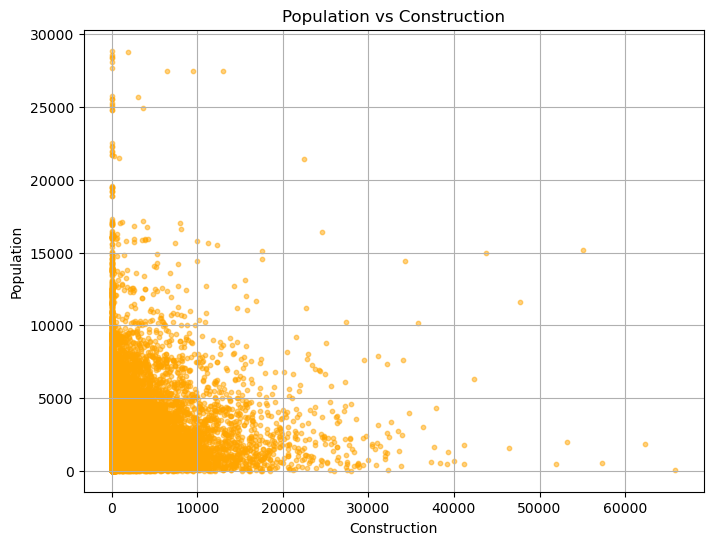

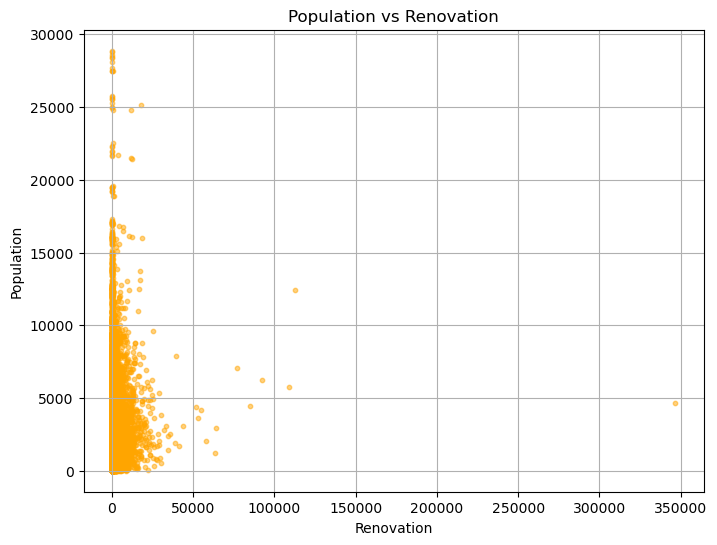

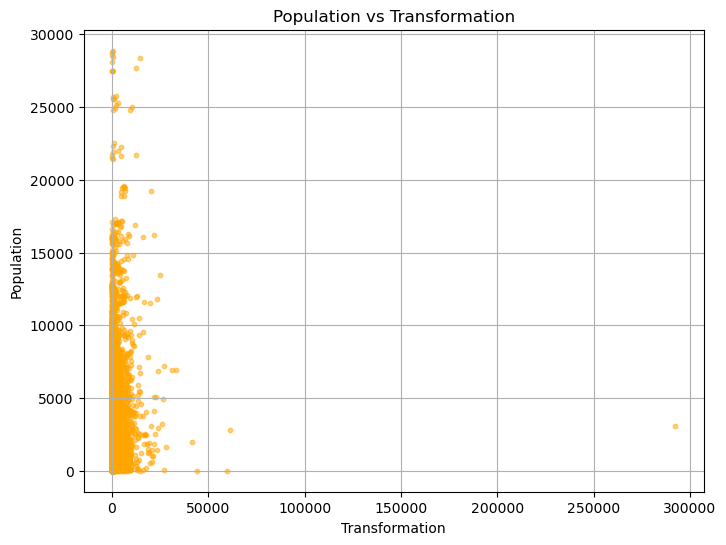

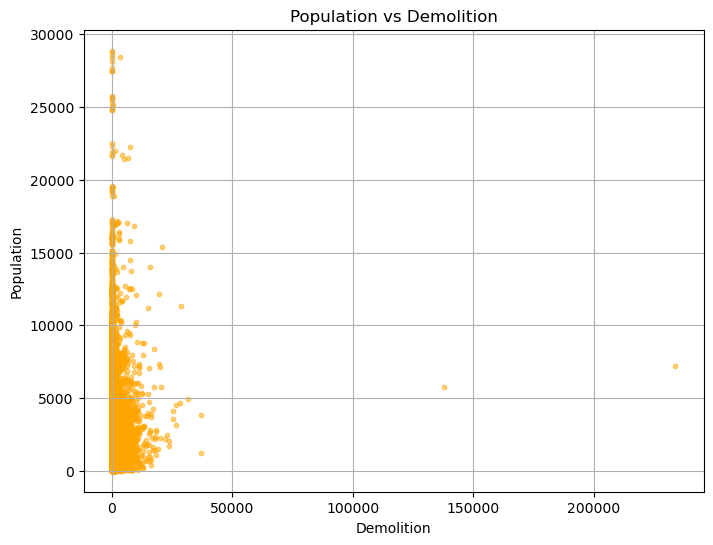

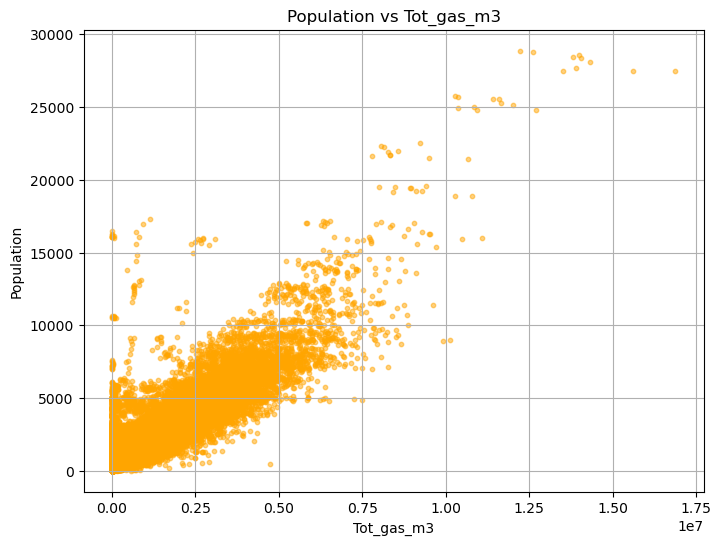

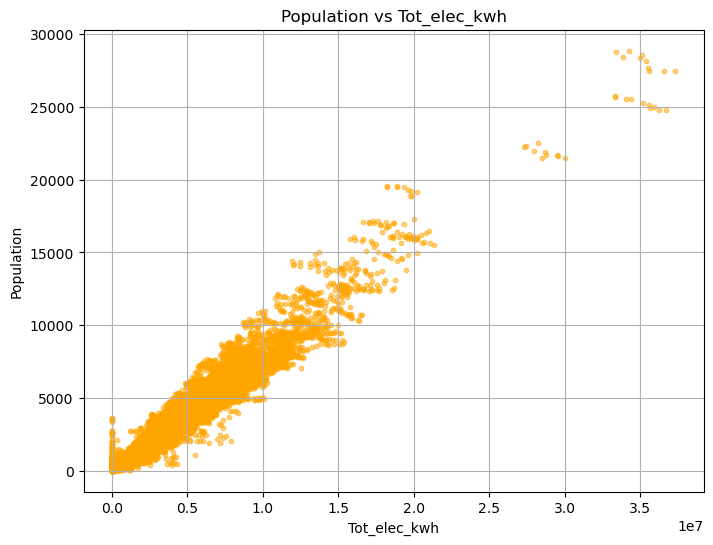

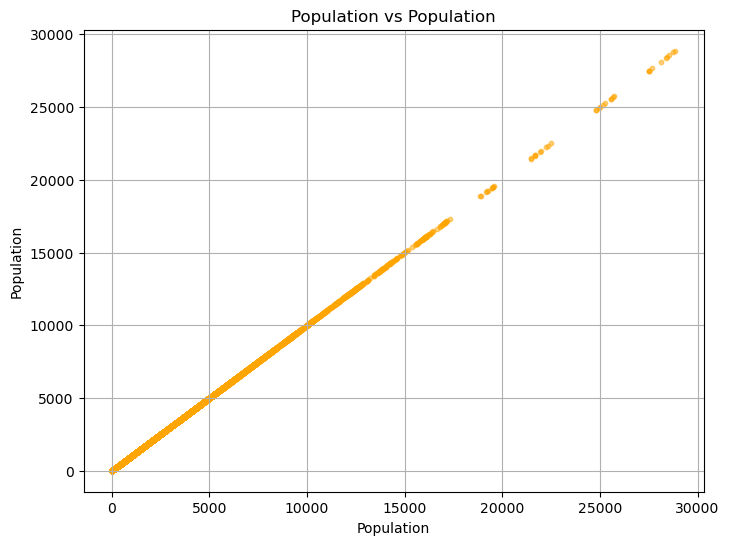

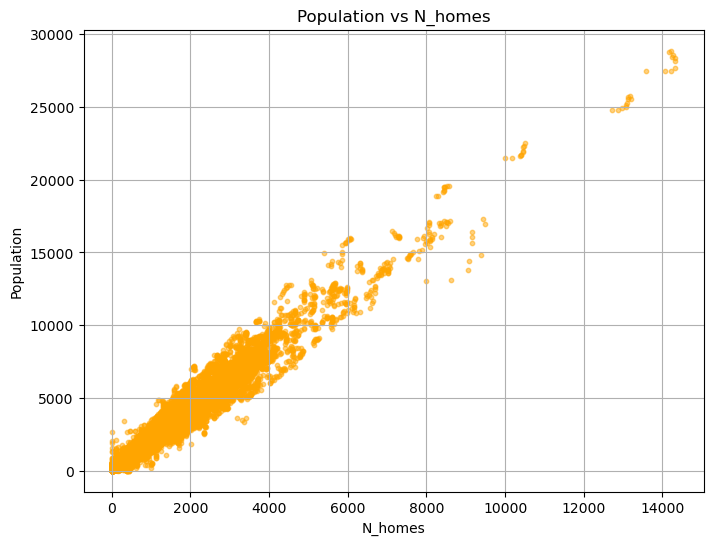

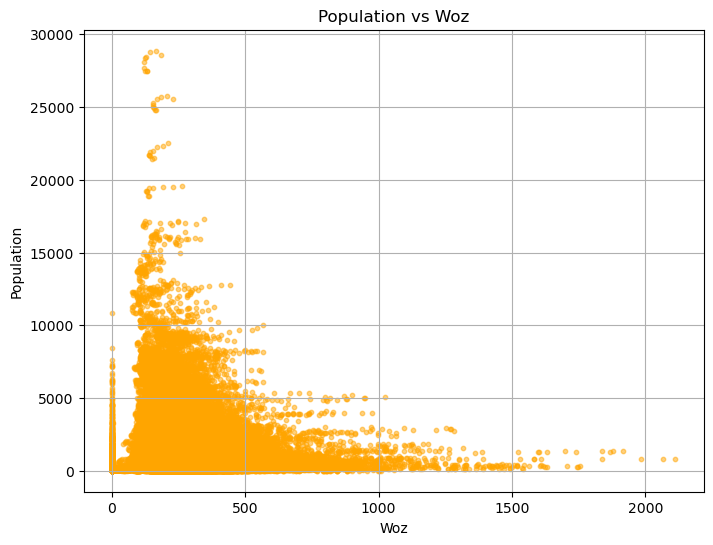

In [63]:
activity_columns = ["construction", "renovation", "transformation", "demolition"]
energy_columns = ["tot_gas_m3", "tot_elec_kwh"]
emissions_columns = ["embodied_kg", "operational_kg"]
info_columns = ["population", "n_homes", "woz"]

normalising_column = 'population'

for column_list in [emissions_columns, activity_columns, energy_columns, info_columns]:
    for column in column_list: 
        plt.figure(figsize=(8, 6))
        plt.scatter(data[column], data[normalising_column], alpha=0.5, s=10, color='orange')
        plt.title(f"{normalising_column.capitalize()} vs {column.capitalize()}")
        plt.xlabel(column.capitalize())
        plt.ylabel(normalising_column.capitalize())
        plt.grid(True)
        plt.show()

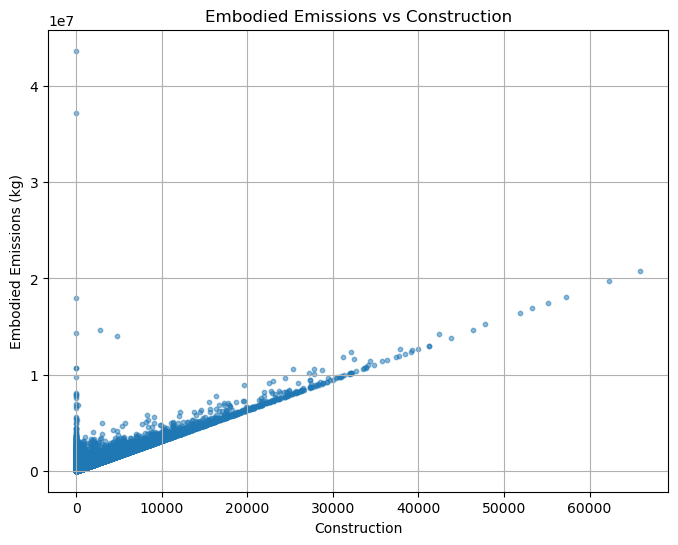

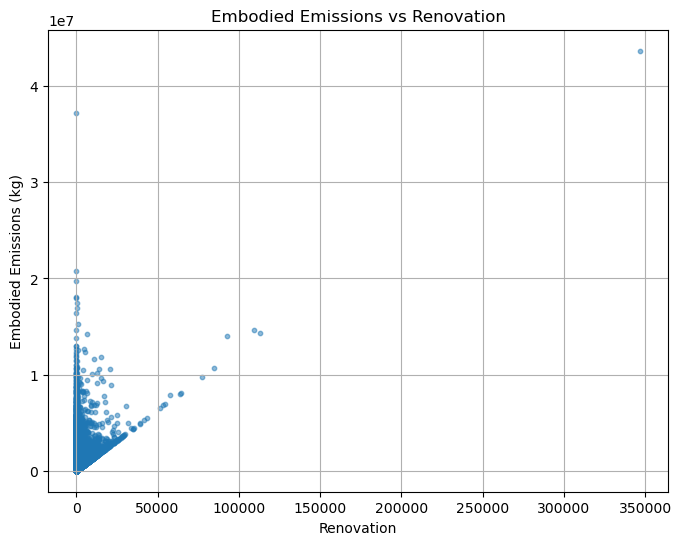

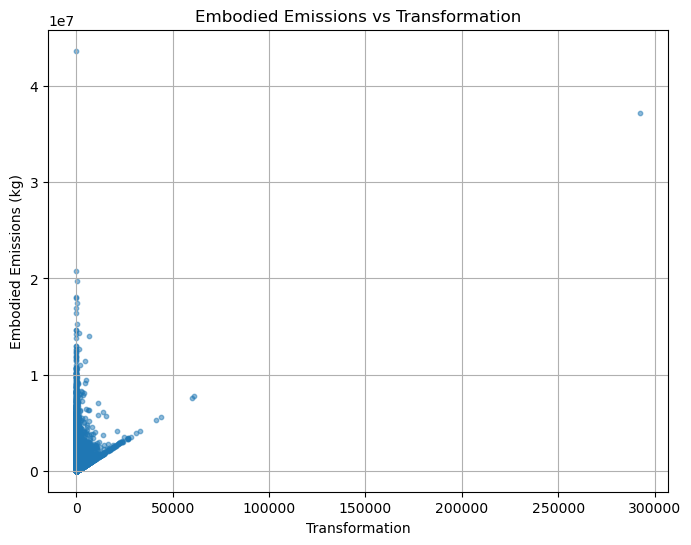

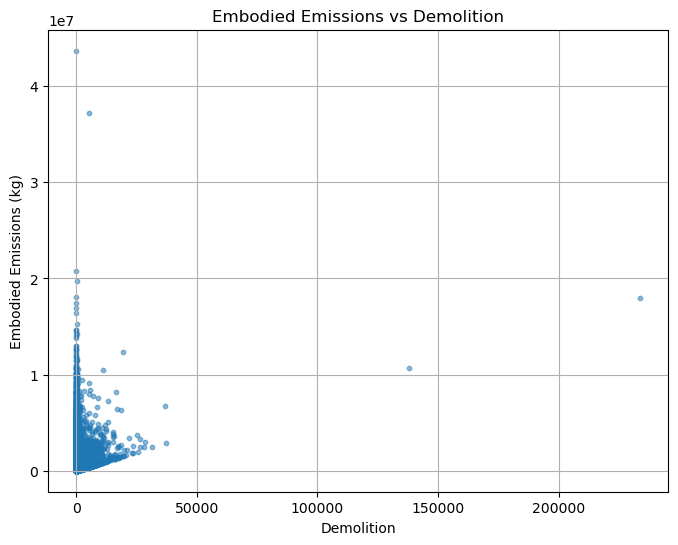

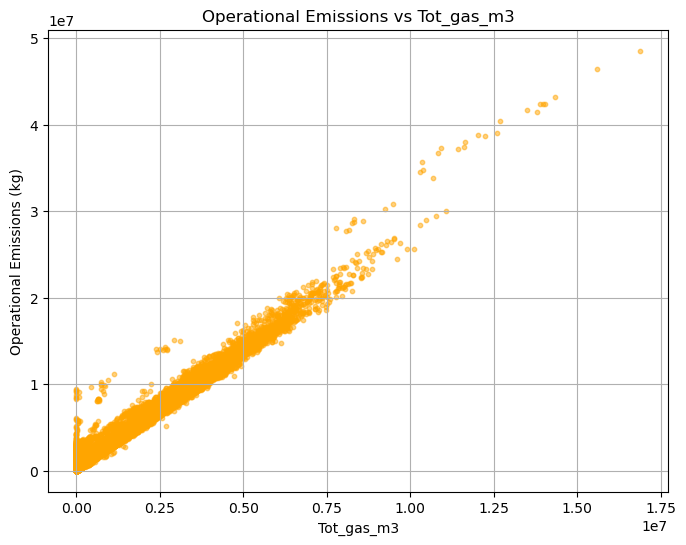

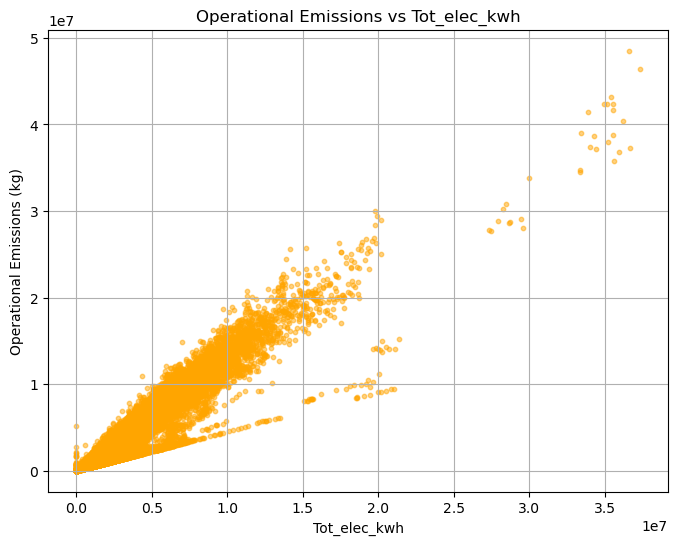

In [21]:
# Activity columns for embodied_kg
embodied_columns = ["construction", "renovation", "transformation", "demolition"]

# Scatterplots for embodied_kg
for activity in embodied_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[activity], data["embodied_kg"], alpha=0.5, s=10)
    plt.title(f"Embodied Emissions vs {activity.capitalize()}")
    plt.xlabel(activity.capitalize())
    plt.ylabel("Embodied Emissions (kg)")
    plt.grid(True)
    plt.show()

# Energy columns for operational_kg
operational_columns = ["tot_gas_m3", "tot_elec_kwh"]

# Scatterplots for operational_kg
for energy in operational_columns:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[energy], data["operational_kg"], alpha=0.5, s=10, color="orange")
    plt.title(f"Operational Emissions vs {energy.capitalize()}")
    plt.xlabel(energy.capitalize())
    plt.ylabel("Operational Emissions (kg)")
    plt.grid(True)
    plt.show()

# Time series trends 

In [22]:
query = ''' 
SELECT 
    year, 
    SUM(construction) AS construction, 
    SUM(renovation) AS renovation, 
    SUM(transformation) AS transformation, 
    SUM(demolition) AS demolition, 
    SUM(population) AS population, 
    SUM(n_homes) AS n_homes, 
    SUM(tot_gas_m3) AS tot_gas_m3, 
    SUM(tot_elec_kwh) AS tot_elec_kwh, 
    SUM(embodied_kg) AS embodied_kg, 
    SUM(operational_kg) AS operational_kg 
FROM emissions_all_buurt 
WHERE municipality IS NOT NULL 
GROUP BY year 
ORDER BY year;
'''

df = pd.read_sql_query(query, engine)

In [28]:
fig = px.line(df, x='year', y=['operational_kg', 'embodied_kg'], title='Total Emissions Over Time')
fig.show()

In [27]:
fig = px.line(df, x='year', y=['tot_gas_m3', 'tot_elec_kwh'], title='Total Energy Consumption by Year')
fig.show()

In [26]:
fig = px.line(df, x='year', y=['population', 'n_homes'], title='Population and Number of Homes Over Time')
fig.show()

In [25]:
fig = px.line(df, x="year", y=['construction', 'renovation', 'transformation', 'demolition'], 
              title='Construction and Renovation Emissions Over Time')
fig.show()

# Mapping

In [29]:
query = ''' 
WITH stats AS (
	SELECT 
	    municipality, 
	    SUM(construction) AS construction, 
	    SUM(renovation) AS renovation, 
	    SUM(transformation) AS transformation, 
	    SUM(demolition) AS demolition, 
	    SUM(population) AS population, 
	    SUM(n_homes) AS n_homes, 
	    SUM(tot_gas_m3) AS tot_gas_m3, 
	    SUM(tot_elec_kwh) AS tot_elec_kwh, 
	    SUM(embodied_kg) AS embodied_kg, 
	    SUM(operational_kg) AS operational_kg 
	FROM emissions_all_buurt 
	WHERE municipality IS NOT NULL 
	GROUP BY municipality 
), 
geoms AS (
	SELECT gemeentenaam AS municipality, geometry
	FROM municipalities_2022 WHERE water = 'NEE'
)

SELECT a.*, b.geometry
FROM stats a 
JOIN geoms b 
ON a.municipality = b.municipality
'''

gdf = gpd.read_postgis(query, engine, geom_col='geometry')

In [46]:
gdf['operational_kg_per_capita'] = gdf['operational_kg'] / gdf['population']
gdf['embodied_kg_per_capita'] = gdf['embodied_kg'] / gdf['population']
gdf['operational_kg_per_home'] = gdf['operational_kg'] / gdf['n_homes']
gdf['embodied_kg_per_home'] = gdf['embodied_kg'] / gdf['n_homes']

gdf['tot_elec_kwh_per_capita'] = gdf['tot_elec_kwh'] / gdf['population']
gdf['tot_gas_m3_per_capita'] = gdf['tot_gas_m3'] / gdf['population']

gdf['construction_per_capita'] = gdf['construction'] / gdf['population']
gdf['renovation_per_capita'] = gdf['renovation'] / gdf['population']
gdf['transformation_per_capita'] = gdf['transformation'] / gdf['population']
gdf['demolition_per_capita'] = gdf['demolition'] / gdf['population']

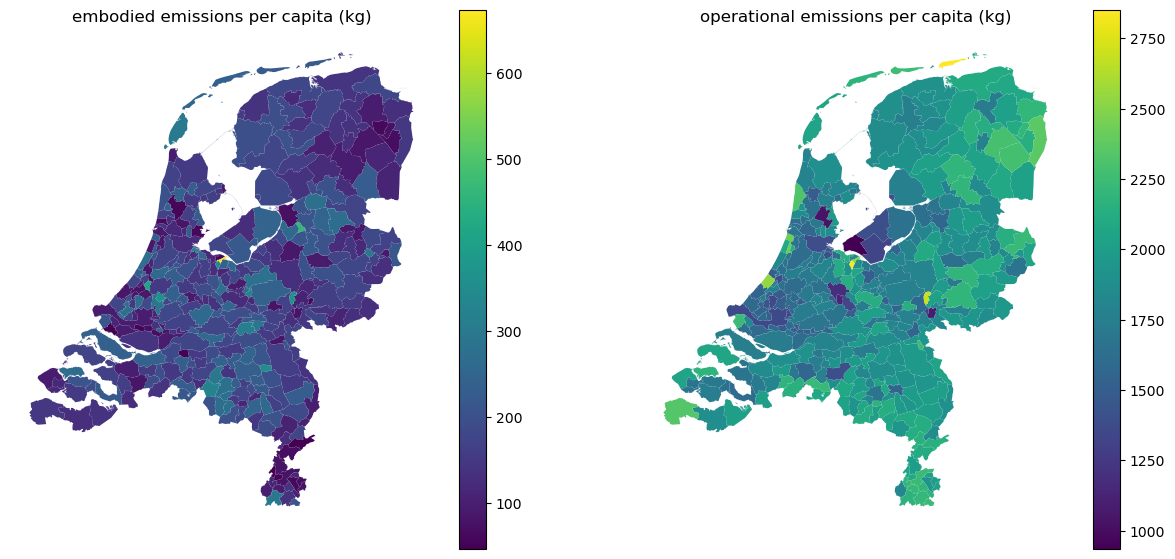

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
gdf.plot(column='embodied_kg_per_capita', legend=True, ax=ax[0])
ax[0].set_title('embodied emissions per capita (kg)')
ax[0].axis('off')
gdf.plot(column='operational_kg_per_capita', legend=True, ax=ax[1])
ax[1].set_title('operational emissions per capita (kg)')
ax[1].axis('off')
plt.show()

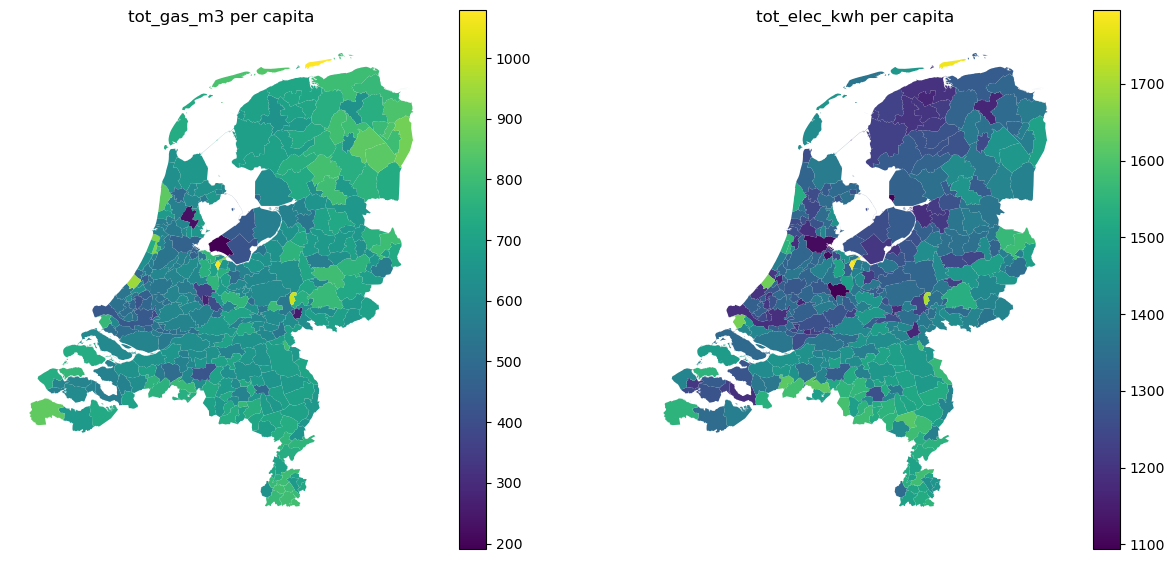

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
gdf.plot(column='tot_gas_m3_per_capita', legend=True, ax=ax[0])
ax[0].set_title('tot_gas_m3 per capita')
ax[0].axis('off')
gdf.plot(column='tot_elec_kwh_per_capita', legend=True, ax=ax[1])
ax[1].set_title('tot_elec_kwh per capita')
ax[1].axis('off')
plt.show()

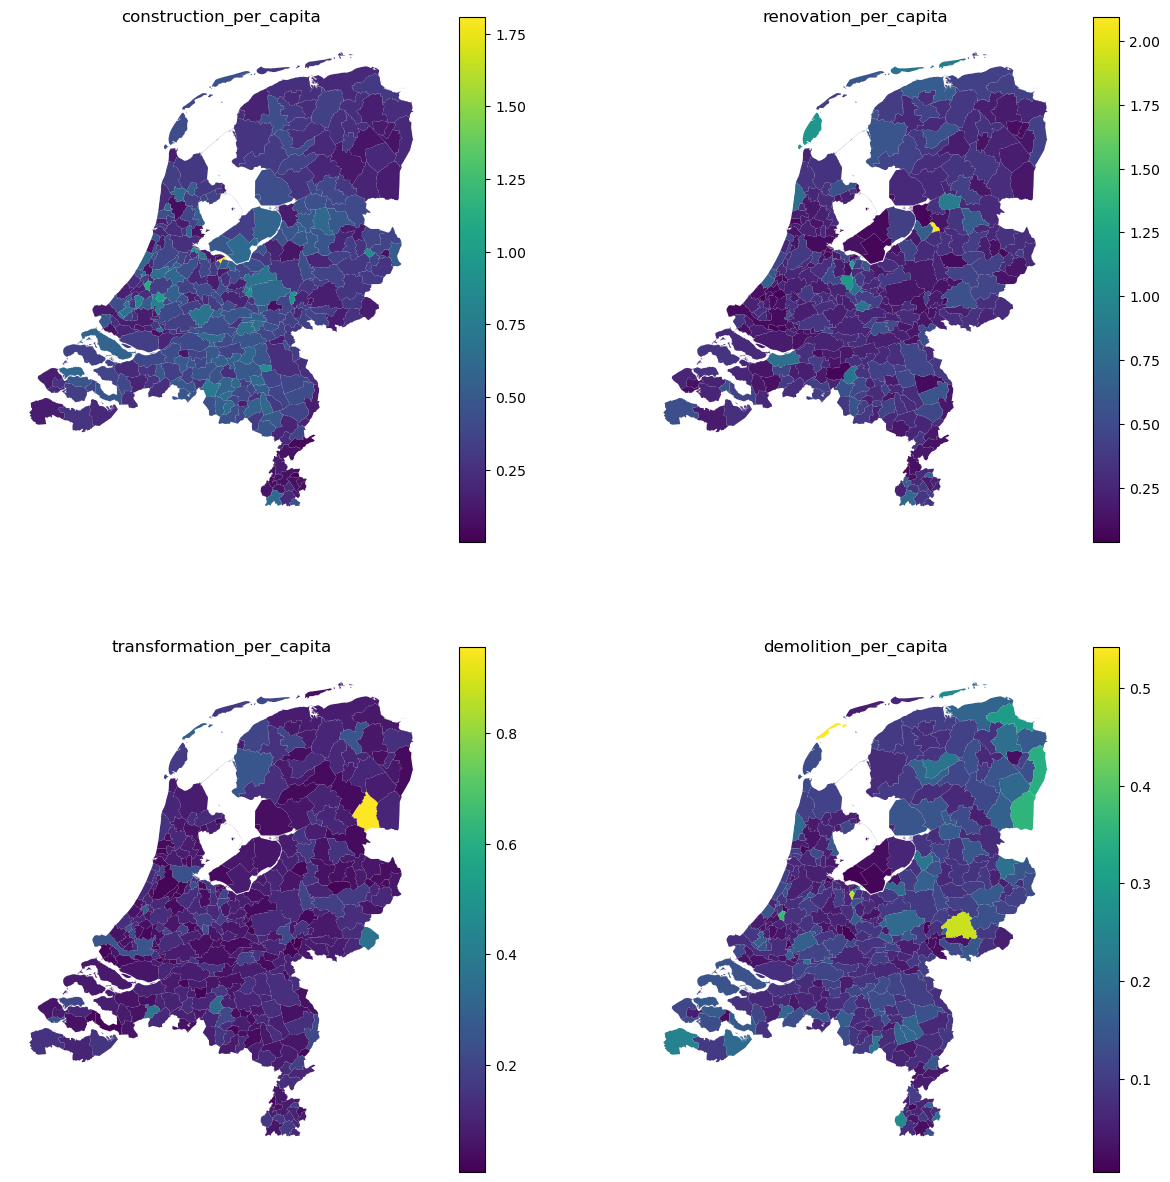

In [50]:
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
gdf.plot(column='construction_per_capita', legend=True, ax=ax[0,0])
ax[0,0].set_title('construction_per_capita')
ax[0,0].axis('off')
gdf.plot(column='renovation_per_capita', legend=True, ax=ax[0,1])
ax[0,1].set_title('renovation_per_capita')
ax[0,1].axis('off')
gdf.plot(column='transformation_per_capita', legend=True, ax=ax[1,0])
ax[1,0].set_title('transformation_per_capita')
ax[1,0].axis('off')
gdf.plot(column='demolition_per_capita', legend=True, ax=ax[1,1])
ax[1,1].set_title('demolition_per_capita')
ax[1,1].axis('off')
plt.show()

# Outliers

In [114]:
query = ''' 
WITH construction_outliers AS (
    SELECT 'construction' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY construction DESC 
    LIMIT 100
),
renovation_outliers AS (
    SELECT 'renovation' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY renovation DESC 
    LIMIT 100
),
transformation_outliers AS (
    SELECT 'transformation' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY transformation DESC 
    LIMIT 100
),
demolition_outliers AS (
    SELECT 'demolition' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY demolition DESC 
    LIMIT 100
),
embodied_outliers AS (
    SELECT 'embodied_kg' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY embodied_kg DESC 
    LIMIT 100
),
operational_outliers AS (
    SELECT 'operational_kg' AS outlier_type, 
           * 
    FROM emissions_all_buurt 
    WHERE municipality IS NOT NULL 
    ORDER BY operational_kg DESC 
    LIMIT 100
)
-- Combine all outliers into one table
SELECT * FROM construction_outliers
UNION ALL
SELECT * FROM renovation_outliers
UNION ALL
SELECT * FROM transformation_outliers
UNION ALL
SELECT * FROM demolition_outliers
UNION ALL
SELECT * FROM embodied_outliers
UNION ALL
SELECT * FROM operational_outliers;

'''

gdf = gpd.read_postgis(query, engine, geom_col='bu_geom')

<Axes: >

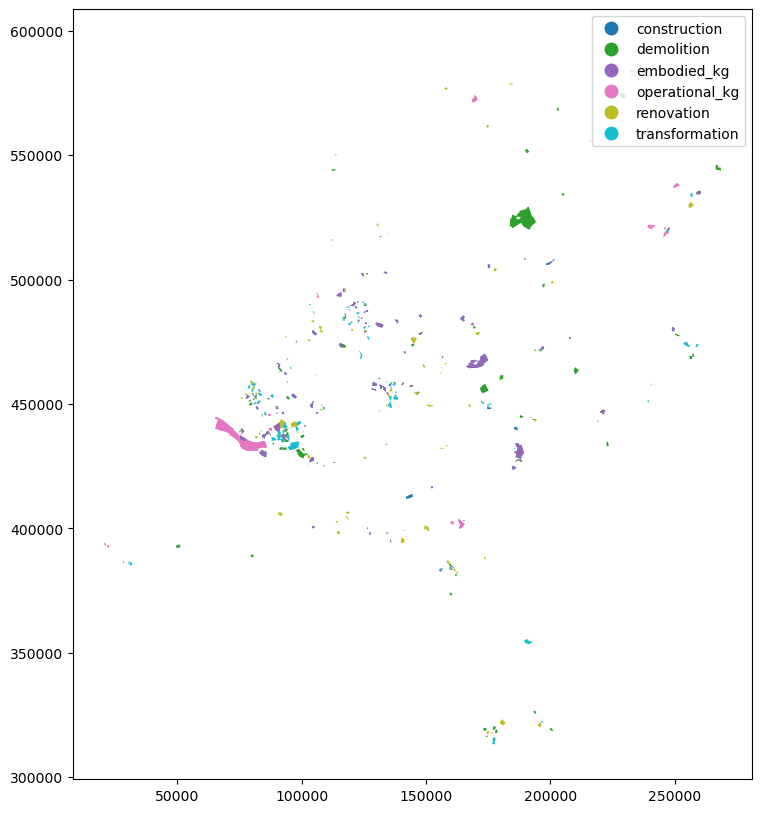

In [117]:
column_name = 'construction'
gdf.plot(column='outlier_type', legend=True, figsize=(10, 10))